# Correlation Analysis

Correlation analysis reveals relationships between features, identifies multicollinearity, and guides feature grouping for dimensionality reduction.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from ama_tlbx.analysis import FeatureGroup, suggest_groups_from_correlation
from ama_tlbx.data import LifeExpectancyDataset, LECol
from ama_tlbx.plotting.correlation_plots import (
    plot_correlation_heatmap,
    plot_top_correlated_pairs,
    plot_target_correlations,
)

np.random.seed(42)

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.titlesize"] = 12
plt.rcParams["figure.labelsize"] = 11
plt.rcParams["figure.titleweight"] = "bold"


In [2]:
ds = LifeExpectancyDataset.from_csv(aggregate_by_country=False)

corr_result = ds.make_correlation_analyzer().fit().result()


## 1. Correlation Matrix Heatmap

Shows pairwise correlations between all numeric features.

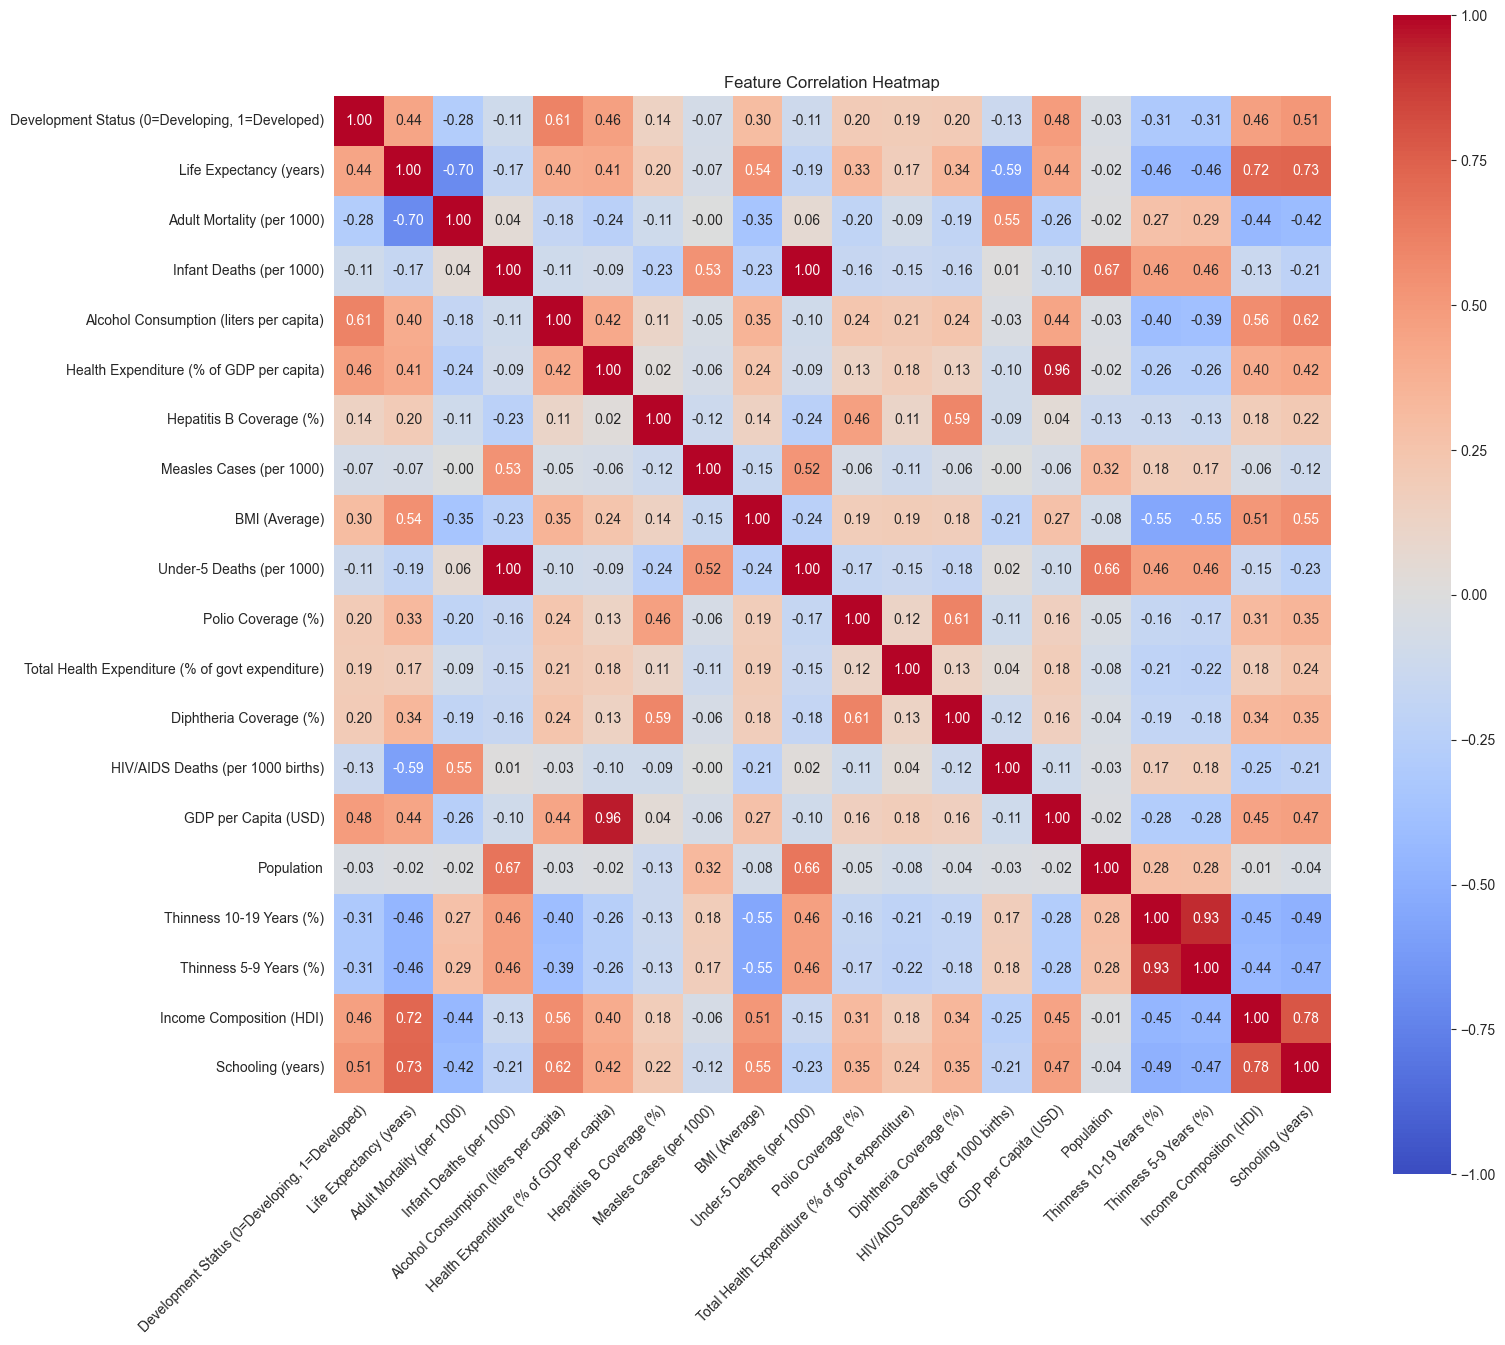

# dev - Correlation matrix shape: (20, 20)


In [ ]:
fig = plot_correlation_heatmap(corr_result, figsize=(16, 16))
plt.show()


## 2. Top Correlated Feature Pairs

Identifies the strongest positive and negative correlations for targeted analysis.

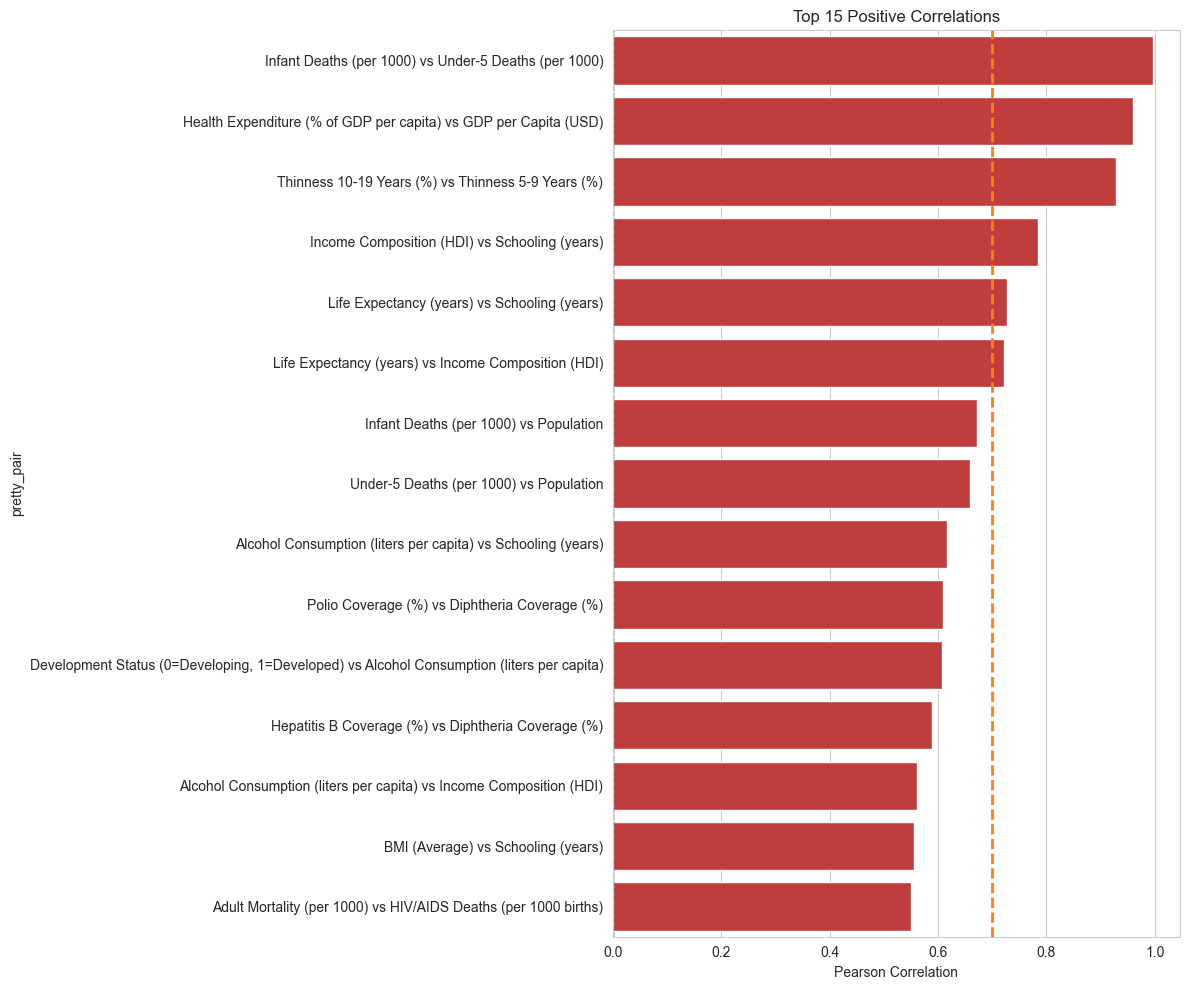

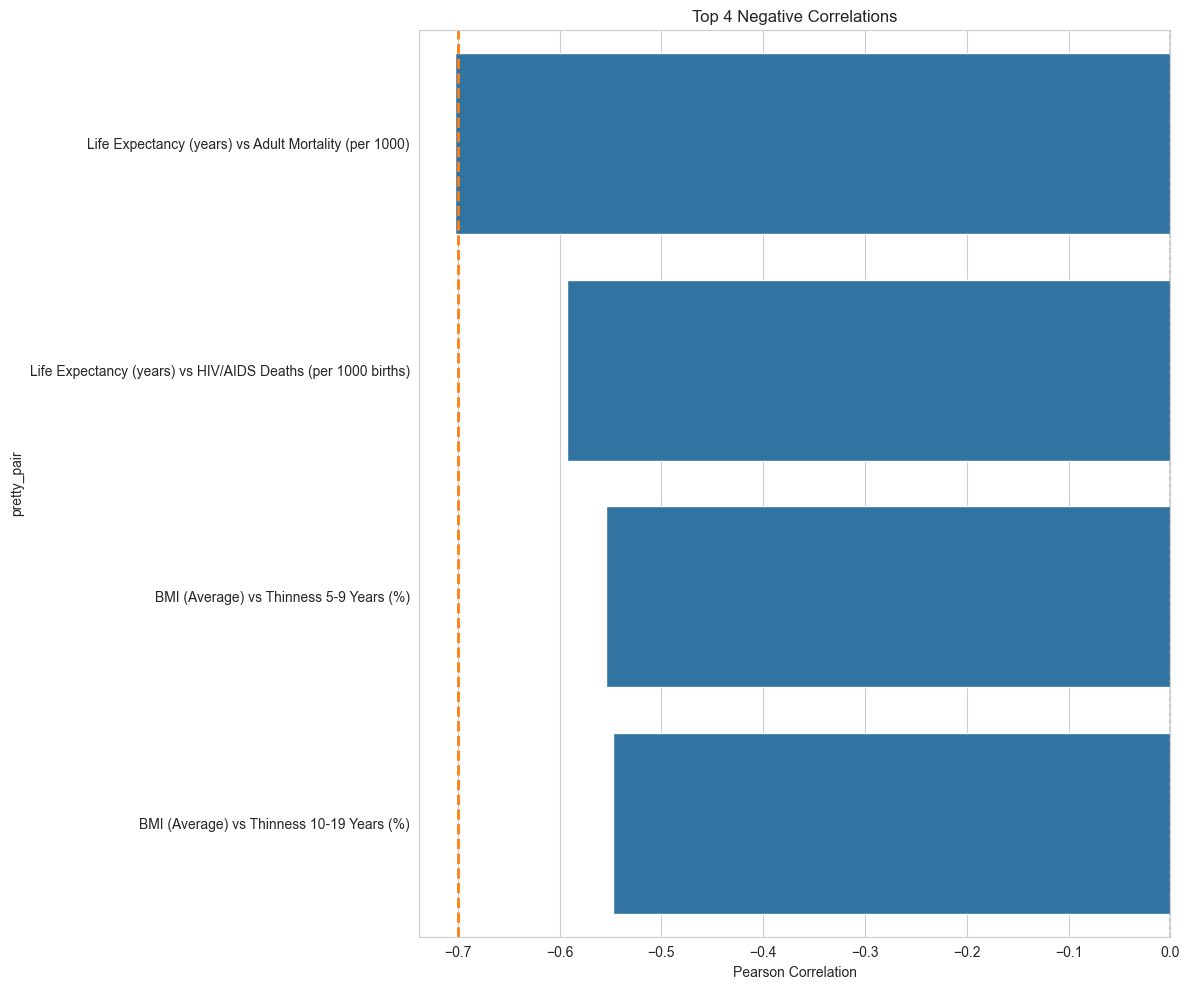

In [ ]:
fig_pos, fig_neg = plot_top_correlated_pairs(corr_result, n=15, threshold=0.7)
plt.show()


## 3. Top Correlated Target Features

Identifies the strongest positive and negative correlations with the target variable.

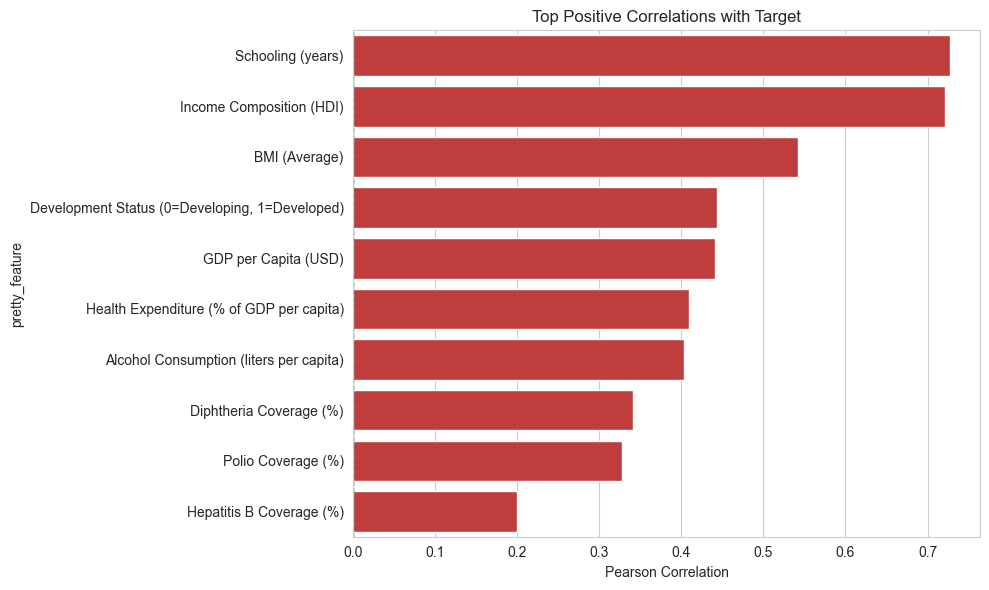

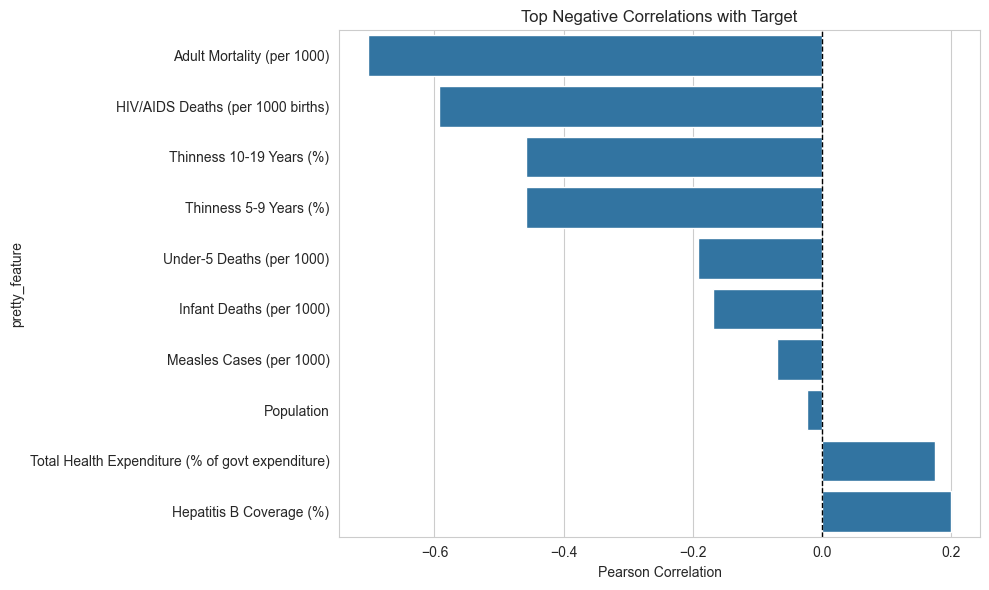

In [8]:
plot_target_correlations(result=corr_result)
plt.show()


## 4. Automatic Feature Grouping Suggestion

Uses correlation structure to suggest feature groups for PCA dimensionality reduction.

In [6]:
suggested_groups = suggest_groups_from_correlation(
    corr_result.matrix, threshold=0.8, min_group_size=2
)

print("Suggested Feature Groups (|r| > 0.8):")
print("=" * 80)
for group in suggested_groups:
    print(f"\n{group.name} ({len(group.features)} features):")
    for feat in group.features:
        pretty = ds.get_pretty_name(feat)
        print(f"  - {feat:30s} ({pretty})")


Suggested Feature Groups (|r| > 0.8):

Group_1 (2 features):
  - infant_deaths                  (Infant Deaths (per 1000))
  - under_five_deaths              (Under-5 Deaths (per 1000))

Group_9 (2 features):
  - thinness_1_19_years            (Thinness 10-19 Years (%))
  - thinness_5_9_years             (Thinness 5-9 Years (%))

Group_11 (2 features):
  - percentage_expenditure         (Health Expenditure (% of GDP per capita))
  - gdp                            (GDP per Capita (USD))


## 5. Inspection of Mechanic Correlations

Analyzes correlations among mechanic-related features to understand their interdependencies.

Correlation Matrix:
                          gdp  percentage_expenditure  total_expenditure  \
gdp                     1.000                   0.923              0.141   
percentage_expenditure  0.923                   1.000              0.210   
total_expenditure       0.141                   0.210              1.000   
implied_health_exp      0.839                   0.919              0.154   

                        implied_health_exp  
gdp                                  0.839  
percentage_expenditure               0.919  
total_expenditure                    0.154  
implied_health_exp                   1.000  

Correlation with Life Expectancy:
None


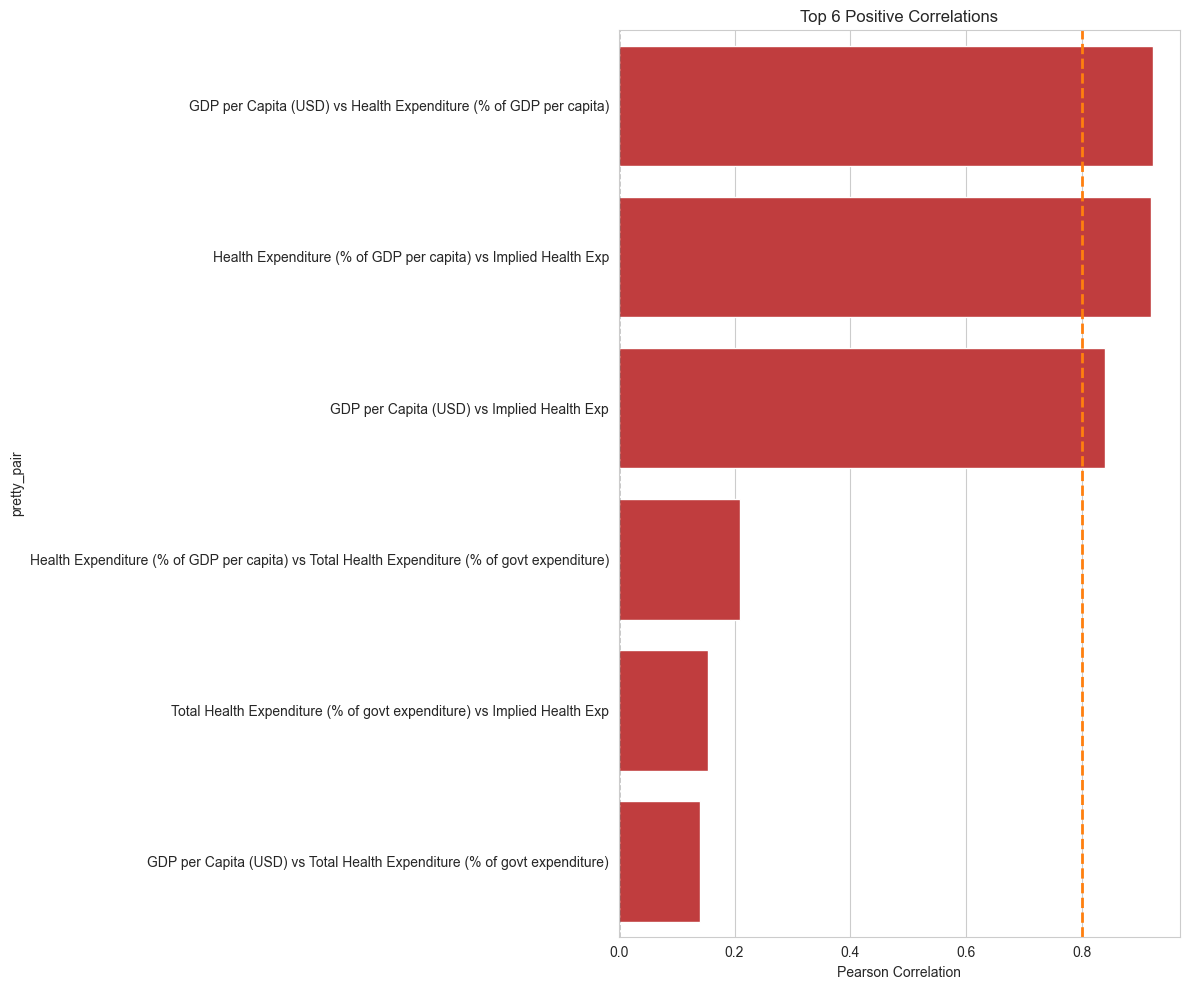

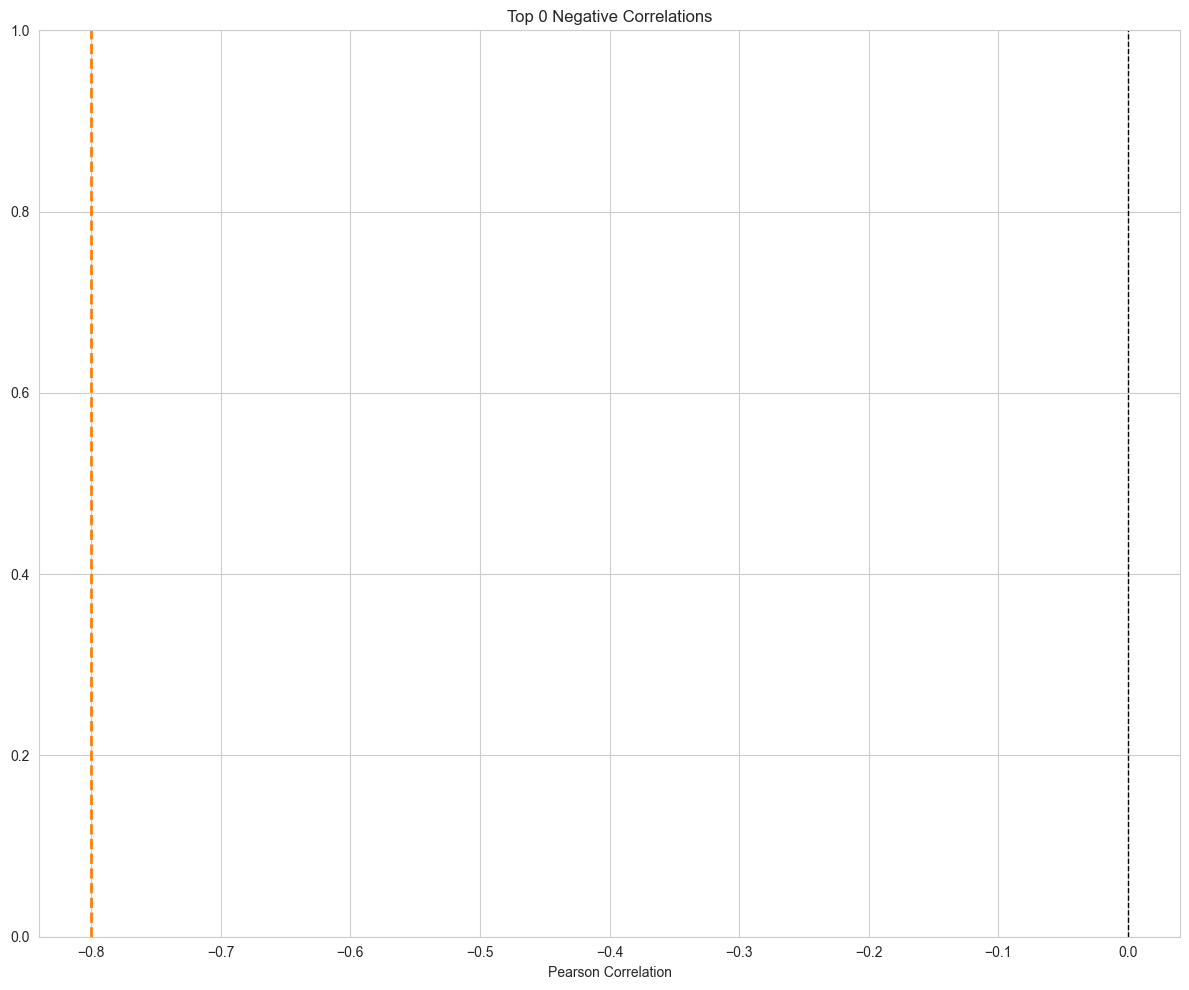

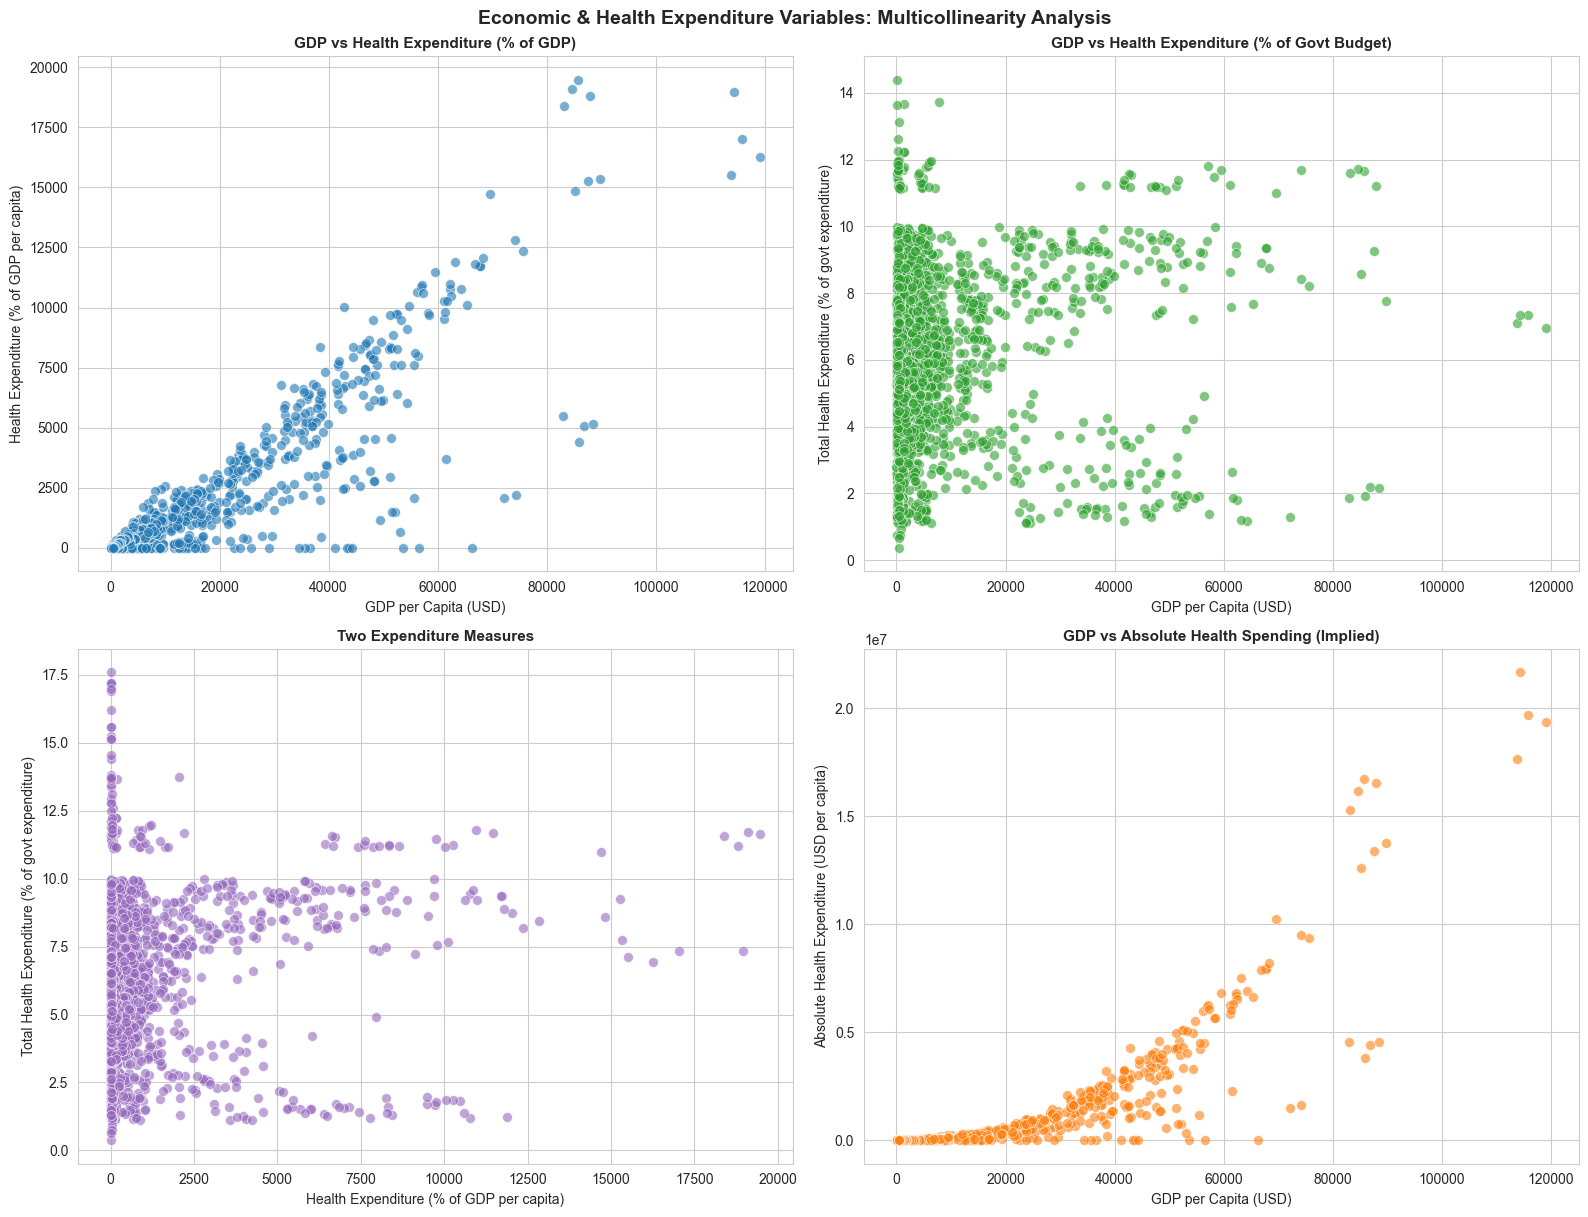

In [ ]:
ds = (
    LifeExpectancyDataset.from_csv(aggregate_by_country=False)
    .df.assign(
        implied_health_exp=lambda df: df[LECol.GDP]
        * df[LECol.PERCENTAGE_EXPENDITURE]
        / (100)
    )
    .pipe(LifeExpectancyDataset)
)


# Analyze the three economic/expenditure variables
econ_vars = [
    LECol.GDP,
    LECol.PERCENTAGE_EXPENDITURE,
    LECol.TOTAL_EXPENDITURE,
    "implied_health_exp",
]

# Correlation analysis
corr_result = (
    ds.make_correlation_analyzer(
        standardized=True, include_target=True, columns=econ_vars
    )
    .fit()
    .result()
)

print("Correlation Matrix:")
print(corr_result.matrix.round(3))
print("\nCorrelation with Life Expectancy:")
print(corr_result.target_correlations)

fig_pos, fig_neg, plot_top_correlated_pairs(corr_result)
plt.close(fig_neg)
plt.show(fig_pos)


# Create pretty names mapping for plotting
plot_cols = {
    LECol.GDP: ds.get_pretty_name(LECol.GDP),
    LECol.PERCENTAGE_EXPENDITURE: ds.get_pretty_name(LECol.PERCENTAGE_EXPENDITURE),
    LECol.TOTAL_EXPENDITURE: ds.get_pretty_name(LECol.TOTAL_EXPENDITURE),
    "implied_health_exp": "Absolute Health Expenditure (USD per capita)",
    LECol.TARGET: ds.get_pretty_name(LECol.TARGET),
}

# Rename columns for plotting
df_plot = ds.df.rename(columns=plot_cols)

# Set seaborn style
sns.set_style("whitegrid")

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: GDP vs Percentage Expenditure (Mechanically Related!)
sns.scatterplot(
    data=df_plot,
    x=plot_cols[LECol.GDP],
    y=plot_cols[LECol.PERCENTAGE_EXPENDITURE],
    alpha=0.6,
    s=50,
    ax=axes[0, 0],
)
axes[0, 0].set_title(
    "GDP vs Health Expenditure (% of GDP)",
    fontweight="bold",
    fontsize=11,
)

# Plot 2: GDP vs Total Expenditure (Independent)
sns.scatterplot(
    data=df_plot,
    x=plot_cols[LECol.GDP],
    y=plot_cols[LECol.TOTAL_EXPENDITURE],
    alpha=0.6,
    s=50,
    color="tab:green",
    ax=axes[0, 1],
)
axes[0, 1].set_title(
    "GDP vs Health Expenditure (% of Govt Budget)",
    fontweight="bold",
    fontsize=11,
)

# Plot 3: Two Expenditure Measures
sns.scatterplot(
    data=df_plot,
    x=plot_cols[LECol.PERCENTAGE_EXPENDITURE],
    y=plot_cols[LECol.TOTAL_EXPENDITURE],
    alpha=0.6,
    s=50,
    color="tab:purple",
    ax=axes[1, 0],
)
axes[1, 0].set_title(
    "Two Expenditure Measures",
    fontweight="bold",
    fontsize=11,
)

# Plot 4: GDP vs Implied Absolute Health Expenditure
sns.scatterplot(
    data=df_plot,
    x=plot_cols[LECol.GDP],
    y=plot_cols["implied_health_exp"],
    alpha=0.6,
    s=50,
    color="tab:orange",
    ax=axes[1, 1],
)
axes[1, 1].set_title(
    "GDP vs Absolute Health Spending (Implied)",
    fontweight="bold",
    fontsize=11,
)

plt.tight_layout()
plt.suptitle(
    "Economic & Health Expenditure Variables: Multicollinearity Analysis",
    fontsize=14,
    fontweight="bold",
    y=1.01,
)
plt.show()
